## Задание

Напишите классификацию заболеваний по базе симптомов, используя любые подходы, связанные с обработкой текстов.

- Embedding + LSTM сеть.
- Embedding + Conv1D сеть.
- Embedding + сложная сеть из Dense, LSTM и Conv1D.

Добейтесь максимальной точности распознавания.
Используйте xLen = 50.



In [0]:
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.python.keras.optimizers import Adam, RMSprop
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split
from google.colab import files
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -q '/content/drive/My Drive/Болезни.zip' -d /content/texts

In [5]:
!ls

drive  sample_data  texts


In [0]:
def readText(fileName):
  f = open(fileName, 'r')
  text = f.read().replace('\n', ' ')
  return text

className = ["Аппендицит", "Гастрит", "Гепатит", "Дуоденит", "Колит", "Панкреатит", 'Холицестит', 'Эзофагит', 'Энтерит', 'Язва']
nClasses = len(className)

trainText = []
testText = []
import re
regex = re.compile('\W+')

for i in className:
  fileName = 'texts/Болезни/' + i + '.txt'
  text = readText(fileName)
  trainText.append(regex.sub(' ', text))

base_text = trainText.copy()
for i, t in enumerate(trainText):
  testText.append(trainText[i][-len(trainText[i])*3//10:])
  trainText[i] = t[:-len(trainText[i])*3//10]

In [0]:
tokenizer = Tokenizer(num_words=500, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainText)
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)

In [0]:
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
  return xSample

def createSetsMultiClasses(wordIndexes, xLen, step):
  nClasses = len(wordIndexes)
  classesXSamples = []
  for wI in wordIndexes:
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) 
  xSamples = []
  ySamples = []
  for t in range(nClasses):
    xT = classesXSamples[t]
    for i in range(len(xT)):
      xSamples.append(xT[i])
      ySamples.append(utils.to_categorical(t, nClasses))
  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)
  return (xSamples, ySamples)

In [0]:
xLen = 50
step = 5

In [0]:
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)

Epoch 1/20
42/42 [==============================] - 1s 25ms/step - loss: 2.1897 - accuracy: 0.1948 - val_loss: 2.2827 - val_accuracy: 0.1892
Epoch 2/20
42/42 [==============================] - 1s 13ms/step - loss: 1.9250 - accuracy: 0.3572 - val_loss: 2.2698 - val_accuracy: 0.1400
Epoch 3/20
42/42 [==============================] - 1s 14ms/step - loss: 1.6337 - accuracy: 0.4222 - val_loss: 2.2066 - val_accuracy: 0.3219
Epoch 4/20
42/42 [==============================] - 1s 14ms/step - loss: 1.4489 - accuracy: 0.4890 - val_loss: 2.1468 - val_accuracy: 0.2654
Epoch 5/20
42/42 [==============================] - 1s 14ms/step - loss: 1.3127 - accuracy: 0.5406 - val_loss: 2.1015 - val_accuracy: 0.2162
Epoch 6/20
42/42 [==============================] - 1s 14ms/step - loss: 1.1931 - accuracy: 0.5817 - val_loss: 2.0428 - val_accuracy: 0.2776
Epoch 7/20
42/42 [==============================] - 1s 14ms/step - loss: 1.0933 - accuracy: 0.6418 - val_loss: 1.9148 - val_accuracy: 0.3194
Epoch 8/20
42

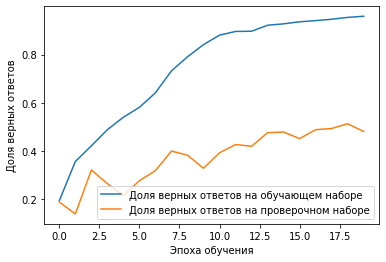

In [43]:
model = Sequential()
model.add(Embedding(500, 12, input_length=xLen))
model.add(LSTM(4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=25,
                    validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Epoch 1/30
42/42 [==============================] - 0s 9ms/step - loss: 2.5271 - accuracy: 0.1423 - val_loss: 2.2234 - val_accuracy: 0.2064
Epoch 2/30
42/42 [==============================] - 0s 7ms/step - loss: 1.7601 - accuracy: 0.4088 - val_loss: 2.1958 - val_accuracy: 0.2064
Epoch 3/30
42/42 [==============================] - 0s 7ms/step - loss: 1.1378 - accuracy: 0.6753 - val_loss: 2.1762 - val_accuracy: 0.2727
Epoch 4/30
42/42 [==============================] - 0s 6ms/step - loss: 0.6318 - accuracy: 0.8825 - val_loss: 2.1521 - val_accuracy: 0.2752
Epoch 5/30
42/42 [==============================] - 0s 6ms/step - loss: 0.3583 - accuracy: 0.9580 - val_loss: 2.1158 - val_accuracy: 0.2703
Epoch 6/30
42/42 [==============================] - 0s 6ms/step - loss: 0.2199 - accuracy: 0.9885 - val_loss: 2.0702 - val_accuracy: 0.3047
Epoch 7/30
42/42 [==============================] - 0s 6ms/step - loss: 0.1497 - accuracy: 0.9885 - val_loss: 2.0237 - val_accuracy: 0.3415
Epoch 8/30
42/42 [==

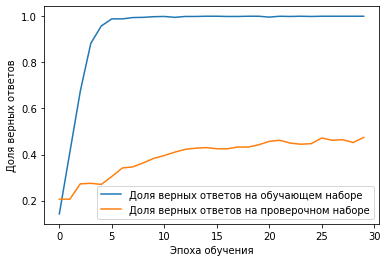

In [44]:
model = Sequential()
model.add(Embedding(500, 12, input_length=xLen))
model.add(SpatialDropout1D(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(xTrain, 
                    yTrain, 
                    epochs=30,
                    batch_size=25,
                    validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Epoch 1/30
42/42 [==============================] - 1s 25ms/step - loss: 2.2786 - accuracy: 0.1671 - val_loss: 2.2861 - val_accuracy: 0.2064
Epoch 2/30
42/42 [==============================] - 1s 14ms/step - loss: 2.1256 - accuracy: 0.2942 - val_loss: 2.2706 - val_accuracy: 0.2113
Epoch 3/30
42/42 [==============================] - 1s 14ms/step - loss: 1.9668 - accuracy: 0.3706 - val_loss: 2.2511 - val_accuracy: 0.2162
Epoch 4/30
42/42 [==============================] - 1s 14ms/step - loss: 1.7493 - accuracy: 0.4565 - val_loss: 2.2130 - val_accuracy: 0.3194
Epoch 5/30
42/42 [==============================] - 1s 14ms/step - loss: 1.5932 - accuracy: 0.4842 - val_loss: 2.1590 - val_accuracy: 0.2236
Epoch 6/30
42/42 [==============================] - 1s 14ms/step - loss: 1.4815 - accuracy: 0.5291 - val_loss: 2.1199 - val_accuracy: 0.2948
Epoch 7/30
42/42 [==============================] - 1s 14ms/step - loss: 1.3810 - accuracy: 0.5482 - val_loss: 2.1714 - val_accuracy: 0.2064
Epoch 8/30
42

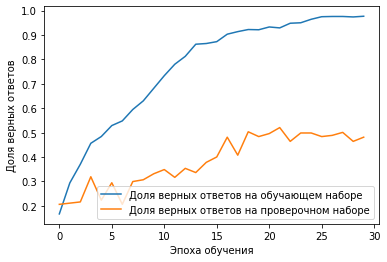

In [45]:
model = Sequential()
model.add(Embedding(500, 12, input_length=xLen))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(xTrain, 
                    yTrain, 
                    epochs=30,
                    batch_size=25,
                    validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Я считаю, что результат явно показывает нам, что xLen 50 - плохая идея. Надеюсь так и было задумано. Бесспорно тут можно наковырять побольше %, пообрабатывая данные получше. Но я полагаю урок извлечен.